# **Project 2 - Predicting flight delays** 
___

In this notebook, I develop a model aimed at predicting flight delays at take-off. The purpose is not to obtain the best possible prediction but rather to emphasize on the various steps needed to build such a model. Along this path, I then put in evidence some **basic but important** concepts. Among then, I comment on the importance of the separation of the dataset during the traning stage and how **cross-validation** helps in determing accurate model parameters. I show how to build **linear** and **polynomial** models for **univariate** or **multivariate regressions** and also, I give some insight on the reason why **regularisation** helps us in developing models that generalize well. 

____
From a **_technical point of view_**, the main aspects of python covered throughout the notebook are:
- **visualization**: matplolib, seaborn, basemap
- **data manipulation**: pandas, numpy
- **modeling**: sklearn, scipy
- **class definition**: regression, figures

During the EDA, I intended to create good quality figures from which the information would be easily accessible at a first glance. An important aspect of the data scientist job consists in divulgating its findings to people who do not necessarily have knowledge in the technical aspects data scientists master. Graphics are surely the most powerful tool to achieve that goal, and mastering visualization techniques thus seems important.

Also, as soon as an action is repeated (mostly at identical) a few times, I tend to write classes or functions and eventually embed them in loops. Doing so is sometimes longer than a simple _copy-paste-edit_ process but,
on the one hand, this improves the readibility of the code and most importantly, this reduces the number of lines of code (and so, the number of opportunities to introduce mistakes !!). In the current notebook, I defined classes in the modeling part in order to perform regressions. I also defined a class to wrap the making of figures. This allows to create stylish figures, by tuning the matplotlib parameters, that can be subsequently re-used thanks to that template. I feel that this could be useful to create nice looking graphics and then use them extensively once you are satisfied with the tuning. Moreover, this helps to keep some homogeneity in your plots.

This notebook is composed of three parts: cleaning (section 1), exploration (section 2-5) and modeling (section 6).

** _Preamble_:** _overview of the dataset_ <br>

** 1. Cleaning** 
- 1.1 Dates and times
- 1.2 Filling factor

**2. Comparing airlines**
- 2.1 Basic statistical description of airlines
- 2.2 Delays distribution: establishing the ranking of airlines 

** 3. Delays: take-off or landing ?** <br>
** 4.  Relation between the origin airport and delays** <br>
- 4.1 Geographical area covered by airlines  <br>
- 4.2 How the origin airport impact delays <br>
- 4.3 Flights with usual delays ? <br>

** 5. Temporal variability of delays** <br>
** 6. Predicting flight delays** <br>
- 6.1 Model nº1: one airline, one airport 
  * 6.1.1 Pitfalls
  * 6.1.2 Polynomial degree: splitting the dataset
  * 6.1.3 Model test: prediction of end-January delays
- 6.2 Model nº2: one airline, all airports
  * 6.2.1 Linear regression  
  * 6.2.2 Polynomial regression
  * 6.2.3 Setting the free parameters
  * 6.2.4 Model test: prediction of end-January delays
- 6.3 Model nº3: Accounting for destinations
   * 6.3.1 Choice of the free parameters
   * 6.3.2 Model test: prediction of end-January delays 
   
**Conclusion**


___
## _Preamble_: overview of the dataset

First, I load all the packages that will be needed during this project:

In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

and then, I read the file that contains the details of all the flights that occured in 2015. I output some informations concerning the types of the variables in the dataframe and the quantity of null values for each variable:

In [4]:
df = pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725


Each entry of the `flights.csv` file corresponds to a flight and we see that more than 5'800'000 flights have been recorded in 2015. These flights are described according to 31 variables. A description of these variables can be found [here](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time) and I briefly recall the meaning of the variables that will be used in this notebook:

- **YEAR, MONTH, DAY, DAY_OF_WEEK**: dates of the flight <br/>
- **AIRLINE**: An identification number assigned by US DOT to identify a unique airline <br/>
- **ORIGIN_AIRPORT** and **DESTINATION_AIRPORT**: code attributed by IATA to identify the airports <br/>
- **SCHEDULED_DEPARTURE** and **SCHEDULED_ARRIVAL** : scheduled times of take-off and landing <br/> 
- **DEPARTURE_TIME** and **ARRIVAL_TIME**: real times at which take-off and landing took place <br/> 
- **DEPARTURE_DELAY** and **ARRIVAL_DELAY**: difference (in minutes) between planned and real times <br/> 
- **DISTANCE**: distance (in miles)  <br/>

An additional file of this dataset, the `airports.csv` file, gives a more exhaustive description of the airports:

In [5]:
airports = pd.read_csv("airports.csv")

To have a global overview of the geographical area covered in this dataset, we can plot the airports location and indicate the number of flights recorded during year 2015 in each of them:

In [6]:
count_flights = df['ORIGIN_AIRPORT'].value_counts()
#___________________________
plt.figure(figsize=(11,11))
#________________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()

NameError: name 'Basemap' is not defined

<Figure size 792x792 with 0 Axes>

Given the large size of the dataset, I decide to consider only a subset of the data in order to reduce the computational time. I will just keep the flights from January 2015:

In [7]:
df = df[df['MONTH'] == 5]

___
## 1. Cleaning
___
### 1.1 Dates and times

In the initial dataframe, dates are coded according to 4 variables: **YEAR, MONTH, DAY**, and **DAY_OF_WEEK**. In fact, python offers the **_datetime_** format which is really convenient to work with dates and times and I thus convert the dates in this format:


In [8]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

Moreover, in the **SCHEDULED_DEPARTURE** variable, the hour of the take-off is coded as a float where the two first digits indicate the hour and the two last, the minutes. This format is not convenient and I thus convert it. Finally, I merge the take-off hour with the flight date. To proceed with these transformations, I define a few functions:

In [9]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

and I call them to modify the dataframe variables:

In [10]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY


Note that in practice, the content of the **DEPARTURE_TIME** and **ARRIVAL_TIME** variables can be a bit misleading since they don't contain the dates. For exemple, in the first entry of the dataframe, the scheduled departure is at 0h05 the 1st of January. The **DEPARTURE_TIME** variable indicates 23h54 and we thus don't know if the flight leaved before time or if there was a large delay. Hence, the **DEPARTURE_DELAY** and **ARRIVAL_DELAY** variables proves more useful since they directly provides the delays in minutes. Hence, in what follows, I will not use the **DEPARTURE_TIME** and **ARRIVAL_TIME** variables.

### 1.2 Filling factor

Finally, I clean the dataframe throwing the variables I won't use and re-organize the columns to ease its reading:

In [11]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
1888622,AA,LAX,PBI,NaT,23:55:00,-10.0,07:52:00,07:47:00,-5.0,287.0,292.0
1888623,US,LAX,PHL,NaT,00:09:00,-2.0,08:25:00,08:28:00,3.0,314.0,319.0
1888624,UA,LAX,IAH,NaT,00:15:00,2.0,05:21:00,05:32:00,11.0,188.0,197.0
1888625,AA,SEA,DFW,NaT,00:04:00,-11.0,06:10:00,05:42:00,-28.0,235.0,218.0
1888626,US,SLC,CLT,NaT,00:17:00,2.0,06:07:00,06:04:00,-3.0,232.0,227.0


At this stage, I examine how complete the dataset is:

In [12]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,SCHEDULED_DEPARTURE,496993,0.000000
1,ARRIVAL_DELAY,7352,98.520704
2,ELAPSED_TIME,7352,98.520704
3,ARRIVAL_TIME,5920,98.808836
4,DEPARTURE_TIME,5336,98.926343
5,DEPARTURE_DELAY,5336,98.926343
6,SCHEDULED_TIME,2,99.999598
7,AIRLINE,0,100.000000
8,ORIGIN_AIRPORT,0,100.000000
9,DESTINATION_AIRPORT,0,100.000000


We see that the variables filling factor is quite good (> 97%). Since the scope of this work is not to establish the state-of-the-art in predicting flight delays, I decide to proceed without trying to impute what's missing and I simply remove the entries that contain missing values.

In [13]:
df.dropna(inplace = True)

___
## 2. Comparing airlines


As said earlier, the **AIRLINE** variable contains the airline abreviations. Their full names can be retrieved from the `airlines.csv` file.

In [14]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


For further use, I put the content of this this dataframe in a dictionary:

In [15]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

___
### 2.1 Basic statistical description of airlines

As a first step, I consider all the flights from all carriers. Here, the aim is to classify the airlines with respect to their punctuality and for that purpose, I compute a few basic statisticial parameters:

In [18]:
from pandas.core.reshape.reshape import unstack

In [19]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'Minimum': group.min(), 'Maximum': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

AttributeError: 'Index' object has no attribute 'remove_unused_levels'

In [17]:
global_stats.shape

NameError: name 'global_stats' is not defined

Now, in order to facilitate the lecture of that information, I construct some graphics:

NameError: name 'global_stats' is not defined

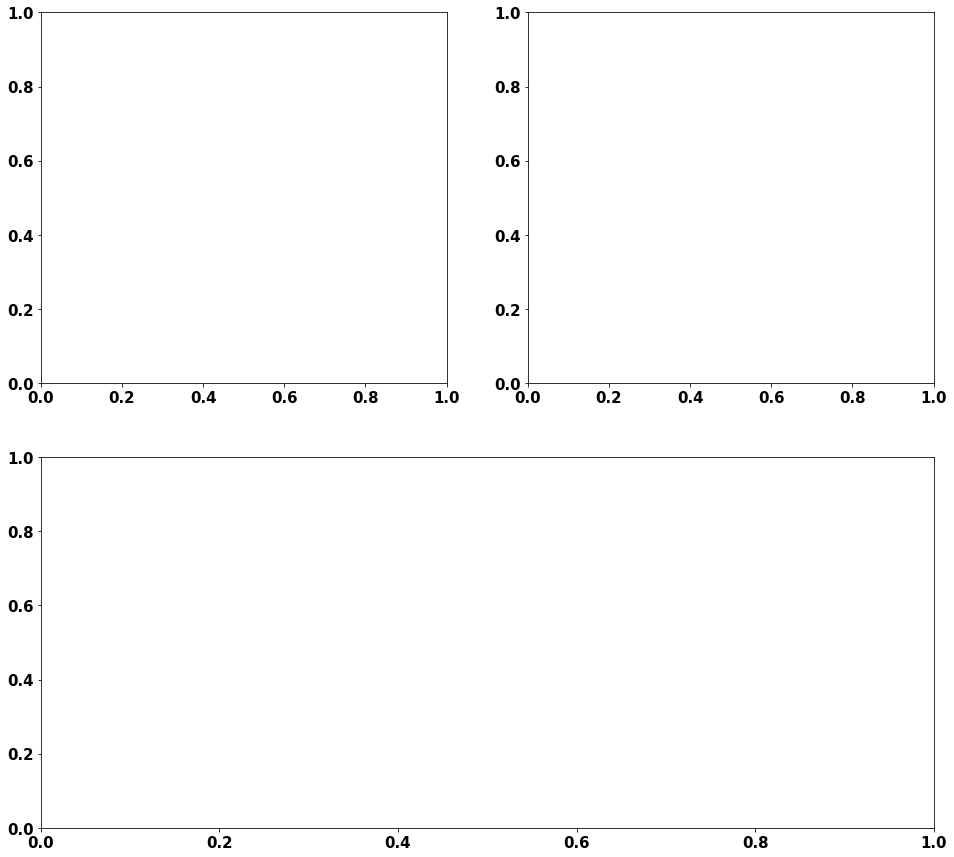

In [34]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

Considering the first pie chart that gives the percentage of flights per airline, we see that there is some disparity between the carriers. For exemple, *Southwest Airlines* accounts for $\sim$20% of the flights which is similar to the number of flights chartered by the 7 tiniest airlines. However, if we have a look at the second pie chart, we see that here, on the contrary, the differences among airlines are less pronounced. Excluding *Hawaiian Airlines* and *Alaska Airlines* that report extremely low mean delays, we obtain that a value of **$\sim$11$\pm$7 minutes** would correctly represent all mean delays. Note that this value is quite low which mean that the standard for every airline is to respect the schedule !

Finally, the figure at the bottom makes a census of all the delays that were measured in January 2015. This representation gives a feeling on the dispersion of data and put in perspective the relative homogeneity that appeared in the second pie chart. Indeed, we see that while all mean delays are around 10 minutes, this low value is a consequence of the fact that a majority of flights take off on time. However, we see that occasionally, we can face really large delays that can reach a few tens of hours !

The large majority of short delays is visible in the next figure:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


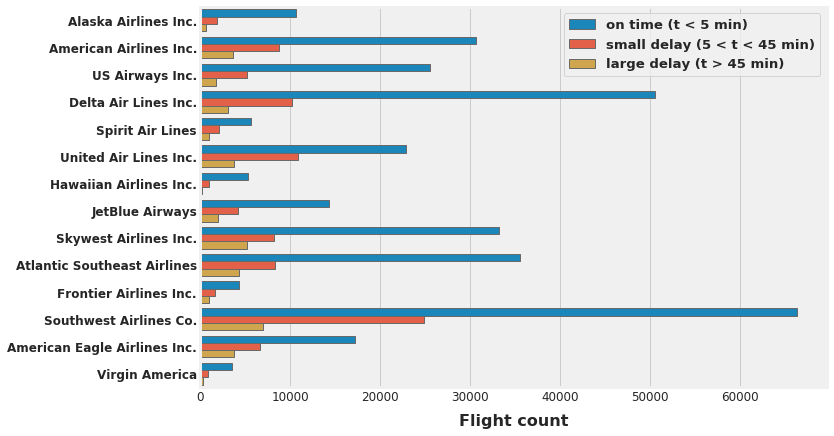

In [116]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

This figure gives a count of the delays of less than 5 minutes, those in the range 5 < t < 45 min and finally, the delays greater than 45 minutes. Hence, we wee that independently of the airline, delays greater than 45 minutes only account for a few percents. However, the proportion of delays in these three groups depends on the airline: as an exemple, in the case of 
*SkyWest Airlines*, the delays greater than 45 minutes are only lower by $\sim$30% with respect to delays in the range 5 < t < 45 min. Things are better for *SoutWest Airlines*  since delays greater than 45 minutes are 4 times less frequent than delays in the range 5 < t < 45 min.


### 2.2 Delays distribution: establishing the ranking of airlines

It was shown in the previous section that mean delays behave homogeneously among airlines (apart from two extrem cases) and is around 11$\pm$7 minutes. Then, we saw that this low value is a consequence of the large proportion of flights that take off on time. However, occasionally, large delays can be registred. In this section, I examine more in details the distribution of delays for every airlines:

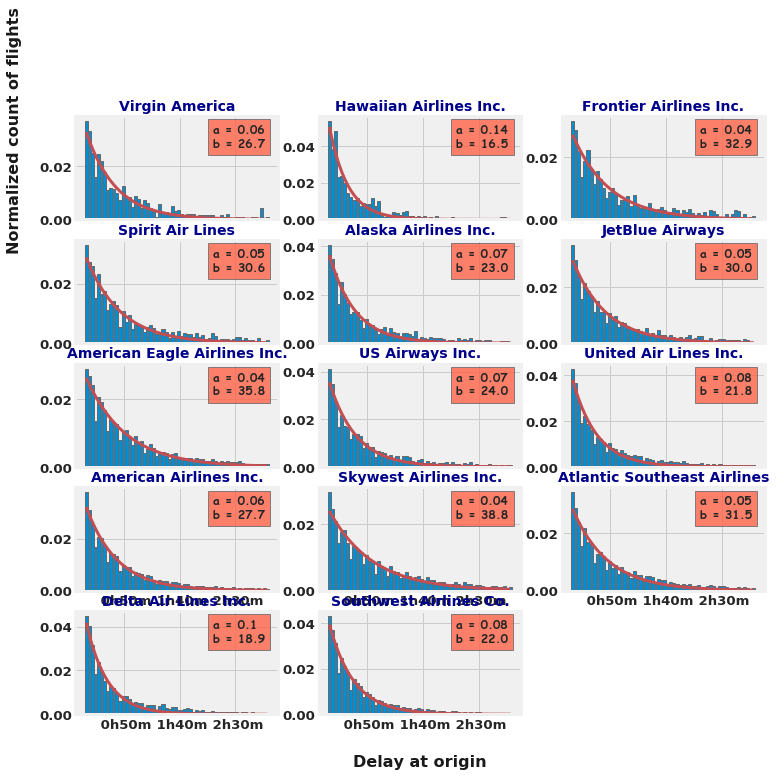

In [117]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

This figure shows the normalised distribution of delays that I modelised with an exponential distribution $ f(x) = a \, \mathrm{exp} (-x/b)$. The $a$ et $b$ parameters obtained to describe each airline are given in the upper right corner of each panel. Note that the normalisation of the distribution implies that $\int f(x) \, dx \sim 1$. Here, we do not have a strict equality since the normalisation applies the histograms but not to the model function. However, this relation entails that the $a$ et $b$ coefficients will be correlated with $a \propto 1/b$ and hence, only one of these two values is necessary to describe the distributions. Finally, according to the value of either $a$ or $b$, it is possible to establish a ranking of the companies: the low values of $a$ will correspond to airlines with a large proportion of important delays and, on the contrary, airlines that shine from their punctuality will admit hight $a$ values:

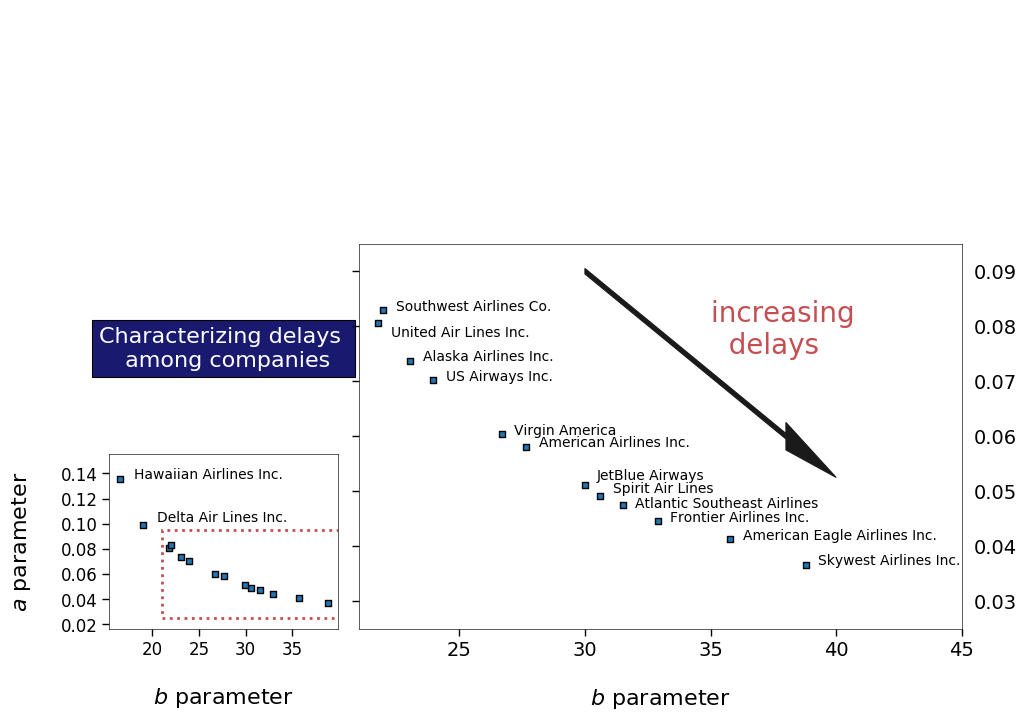

In [118]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

The left panel of this figure gives an overview of the $a$ and $b$ coefficients of the 14 airlines showing that *Hawaiian Airlines* 
and *Delta Airlines* occupy the first two places. The right panel zooms on 12 other airlines. We can see that *SouthWest Airlines*, which represent $\sim$20% of the total number of flights is well ranked and occupy the third position. According to this ranking, *SkyWest Airlines* is the worst carrier.

___
## 3. Delays: take-off or landing ?
In the previous section, all the discussion was done on departure delays. However, these delays differ somewhat from the delays recorded at arrival:

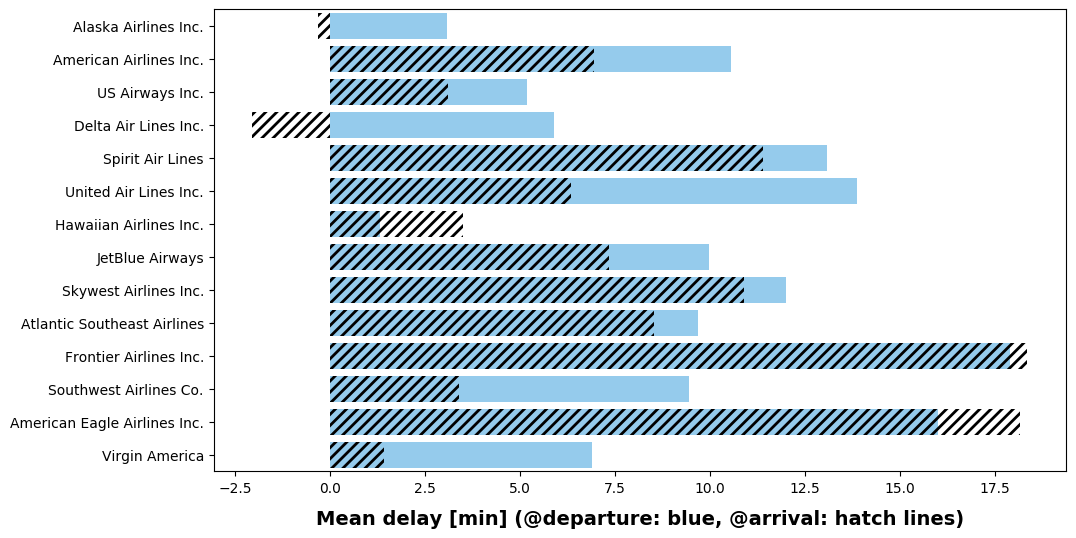

In [119]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

On this figure, we can see that delays at arrival are generally lower than at departure. This indicates that airlines adjust their flight speed in order to reduce the delays at arrival. In what follows, I will just consider the delays at departure but one has to keep in mind that this can differ from arrival delays.

___
## 4. Relation between the origin airport and delays

I will now try to define if there is a correlation between the delays registered and the airport of origin. I recall that in the dataset, the number of airports considered is: 

In [120]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312



### 4.1 Geographical area covered by airlines 

Here, I have a quick look at the number of destination airports for each airline:

In [121]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

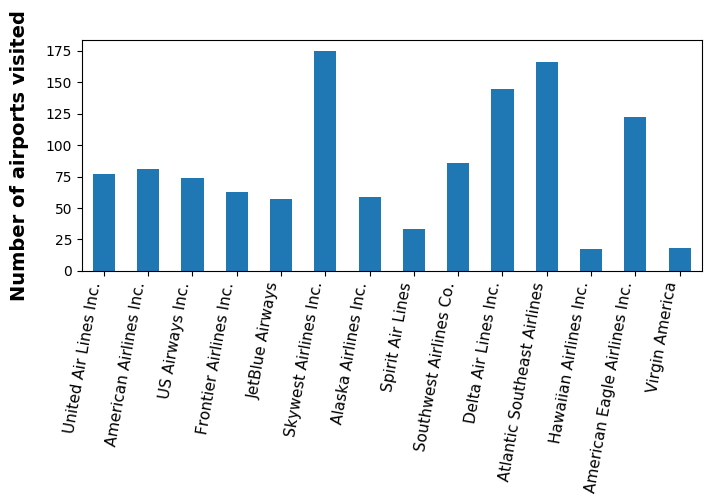

In [122]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [123]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [124]:
def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig=plt.figure(figsize=(7,3))
    ax=fig.add_axes([0.,0.,1.,1.])
    m = Basemap(resolution='i',llcrnrlon=long_min, urcrnrlon=long_max,
                  llcrnrlat=lat_min, urcrnrlat=lat_max, lat_0=0, lon_0=0,)
    df2 = df[df['AIRLINE'] == carrier]
    count_trajectories = df2.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).size()
    count_trajectories.sort_values(inplace = True)
    
    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
                   color = 'seagreen', markeredgecolor='k')

    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
        if pd.isnull(nylat) or pd.isnull(nylon) or \
                pd.isnull(lonlat) or pd.isnull(lonlon): continue
        if s < 100:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b',
                             label = '< 100')
        elif s < 200:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r',
                             label = '100 <.< 200')
        else:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold',
                              label = '> 200')    
    #_____________________________________________
    # remove duplicate labels and set their order
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('< 100', '100 <.< 200', '> 200')                
    new_label = OrderedDict()
    for key in key_order:
        if key not in by_label.keys(): continue
        new_label[key] = by_label[key]
    plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
               title='flights per month', facecolor = 'palegreen', 
               shadow = True, frameon = True, framealpha = 1)    
    m.drawcoastlines()
    m.fillcontinents()
    ax.set_title('{} flights'.format(abbr_companies[carrier]))

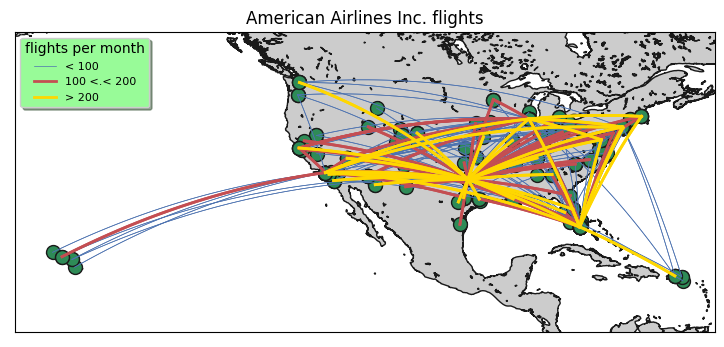

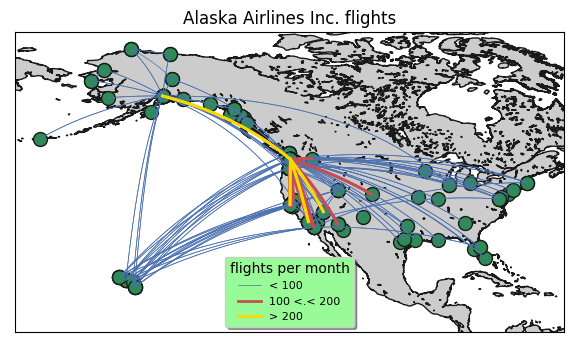

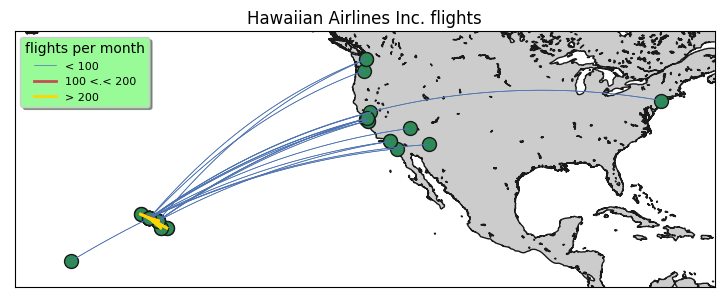

In [125]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['AS'] = [-182, -63, 10, 75]
coord['HA'] = [-180, -65, 10, 52]
for carrier in ['AA', 'AS', 'HA']: 
    make_map(df, carrier, *coord[carrier])

___
### 4.2 How the origin airport impact delays

In this section, I will have a look at the variations of the delays with respect to the origin airport and for every airline. The first step thus consists in determining the mean delays per airport:

In [126]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

Since the number of airports is quite large, a graph showing all the information at once would be a bit messy, since it would represent around 4400 values (i.e. 312 airports $\times$ 14 airlines). Hence, I just represent a subset of the data:

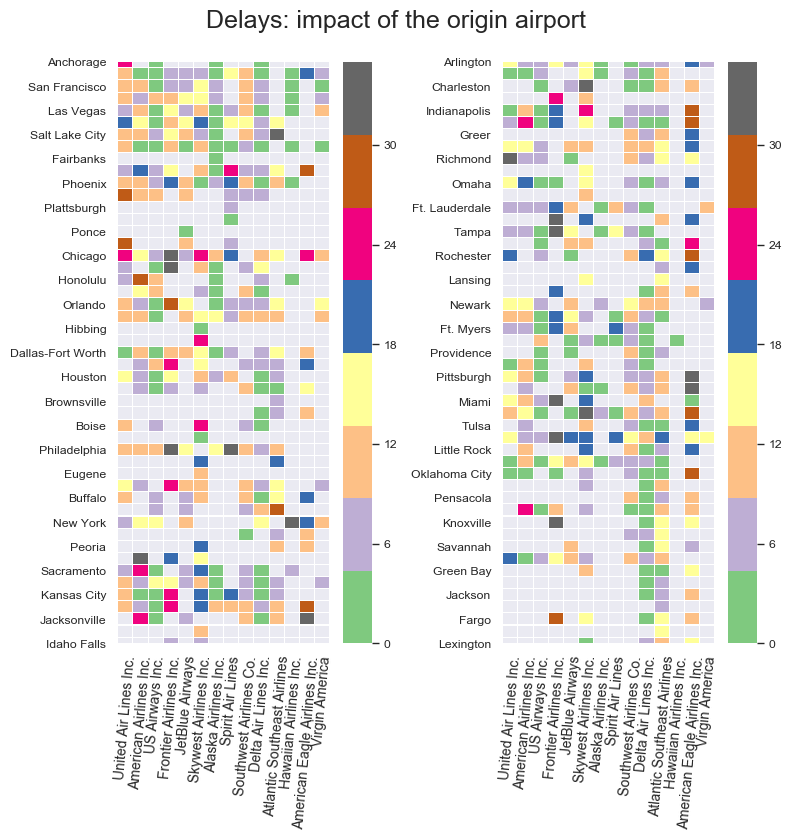

In [127]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

This figure allows to draw some conclusions. First, by looking at the data associated with the different airlines, we find the behavior we previously observed: for example, if we consider the right panel, it will be seen that the column associated with  *American Eagle Airlines* mostly reports large delays, while the column associated with *Delta Airlines* is mainly associated  with delays of less than 5 minutes. If we now look at the airports of origin, we will see that some airports favor late departures: see e.g. Denver, Chicago or New York. Conversely, other airports will mainly know on time departures such as Portland or Oakland.

Finally, we can deduce from these observations that there is a high variability in average delays, both between the different airports but also between the different airlines. This is important because it implies that in order to accurately model the delays, it will be necessary to adopt a model that is ** specific to the company and the home airport **. 

___
### 4.3 Flights with usual delays ?

In the previous section, it has been seen that there is variability in delays when considering the different airlines and the different airports of origin. I'm now going to add a level of granularity by focusing not just on the original airports but on flights: origin $\to$ destination. The objective here is to see if some flights are systematically delayed or if, on the contrary, there are flights that would always be on time.

In the following, I consider the case of a single airline. I list all the flights A $\to$ B carried out by this company and for each of them, I create the list of delays that have been recorded:

In [128]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

I then calculate the average delay on the various paths A $\to$ B, as well as the standard deviation and once done, I create a graphical representation (for a sample of the flights):


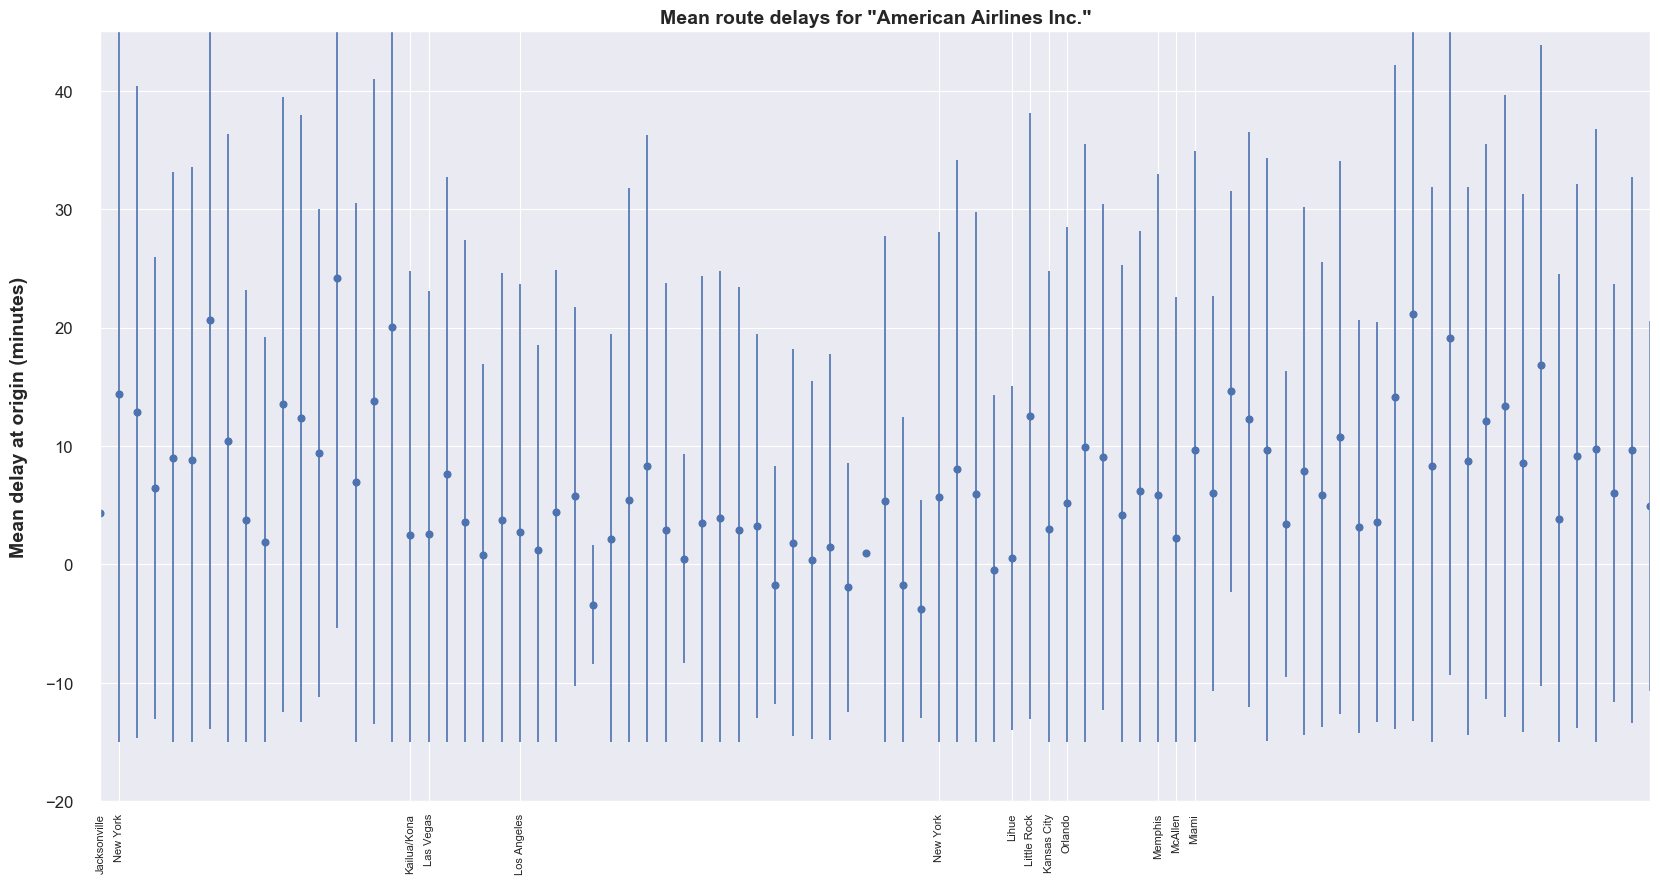

In [129]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(20,10))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

This figure gives the average delays for *American Airlines*, according to the city of origin and the destination (note that on the abscissa axis, only the origin is indicated for the sake of clarity). The error bars associated with the different paths correspond to the standard deviations.
In this example, it can be seen that for a given airport of origin, delays will fluctuate depending on the destination. We see, for example, that here the greatest variations are obtained for New York or Miami where the initial average delays vary between 0 and $\sim$20 minutes.

___
## 4. Temporal variability of delays

In this section, I look at the way delays vary with time. Considering the case of a specific airline and airport, delays can be easily represented by day and time (_aside_: before doing this, I define a class that I will use extensively in what follows to produce graphs):

In [145]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])           

In [131]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

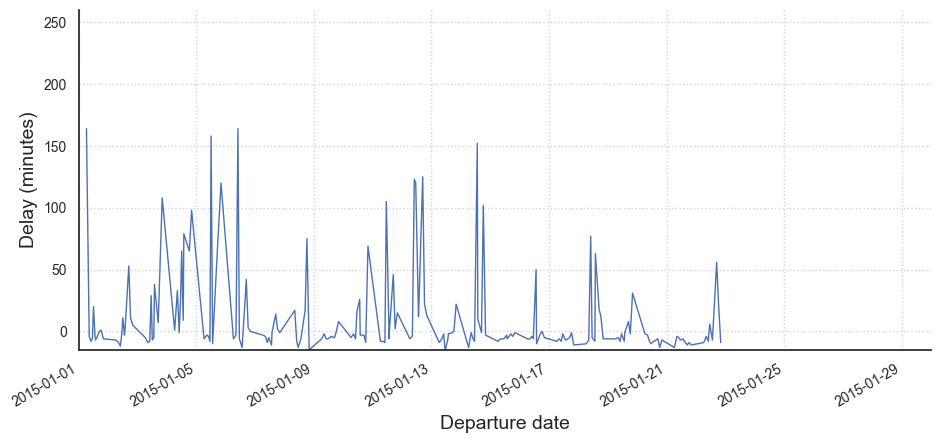

In [146]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,30)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)

This figure shows the existence of cycles, both in the frequency of the delays but also in their magnitude. In fact, intuitively, it seems quite logical to observe such cycles since they will be a consequence of the day-night alternation and the fact that the airport activity will be greatly reduced (if not inexistent) during the night. This suggests that a **important  variable** in the modeling of delays will be **take-off time**. To check this hypothesis, I look at the behavior of the mean delay as a function of departure time, aggregating the data of the current month:

In [133]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

which visually gives:

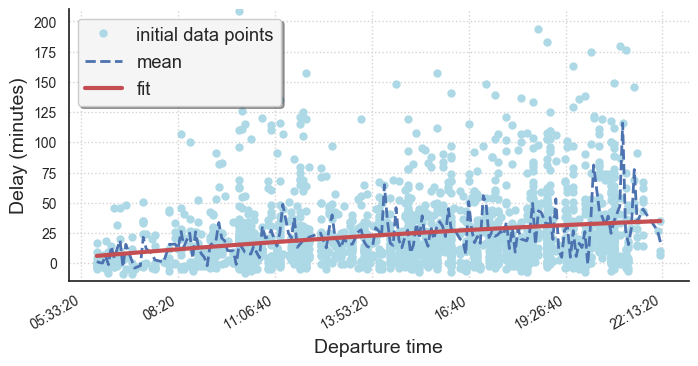

In [134]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot_date(df2['heure_depart'], df2['DEPARTURE_DELAY'],
                    markeredge=False, label='initial data points')
fig1.cust_plot(test2.index, test2['mean'], linestyle='--', linewidth=2, label='mean')
fig1.cust_plot(test2.index, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')
fig1.style() ; fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
fig1.set_ylim(-15, 210)

Here, we can see that the average delay tends to increase with the departure time of day: flights leave on time in the morning  and the delay grows almost monotonously up to 30 minutes at the end of the day. In fact, this behavior is quite general and looking at other aiports or companies, we would find similar trends.

___
## 6. Predicting flight delays 

The previsous sections dealt with an exploration of the dataset. Here, I start with the modeling of flight delays.
In this section, my goal is to create a model that uses a window of 3 weeks to predict the delays of the following week.
Hence, I decide to work on the data of January with the aim of predicting the delays of the epoch $23^{th}-31^{th}$ of Januaray

In [135]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

___
### 5.1 Model nº1: one airline, one airport

I first decide to model the delays by considering separately the different airlines and by splitting the data according to the different home airports. This first model can be seen as a *"toy-model"*  that enables to identify problems that may arise at the  production stage. When treating the whole dataset,  the number of fits will be large. Hence we have to be sure that the automation of the whole process is robust enough to insure the quality of the fits.


#### 5.1.1 Pitfalls <br>


**a) Unsufficient statistics**

First of all, I consider the *American Airlines* flights and make a census of the number of flights that left each airport:

In [136]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,Minimum,Maximum,count,mean
ORIGIN_AIRPORT,,,,
JAC,-19.0,47.0,25.0,-3.640000
GUC,-24.0,199.0,22.0,13.227273
SDF,-8.0,55.0,19.0,8.421053
LIT,-5.0,74.0,9.0,12.555556
MTJ,-2.0,51.0,3.0,26.000000


Looking at this list, we can see that the less visited aiports only have a few flights in a month.
Thus, in the least favorable case, it is impossible to perform a regression.

**b) Extreme delays**

Another pitfall to avoid is that of "accidental" delays: a particular attention should be paid to extreme delays. Indeed, during the exploration, it was seen that occasionally, delays of several hours (even tens of hours) could be recorded. This type of delay is however marginal (a few %) and the cause of these delays is probably linked to unpredictable events (weather, breakdown, accident, ...). On the other hand, taking into account a delay of this type will likely introduce a bias in the analysis. Moreover, the weight taken by large values will be significant if we have a small statistics.

In order to illustrate this, I first define a function that calculates the mean flights delay per airline and per airport: 

In [137]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2


and then a function that performs a linear regression on these values:

In [138]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

I then consider two scenarios. In the first case, I take all the initial values and in the second case, I eliminate all delays greater than 1h before calculating the average delay. The comparison of the two cases is quite explicit:

In [139]:
id_airport = 'PHL'
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

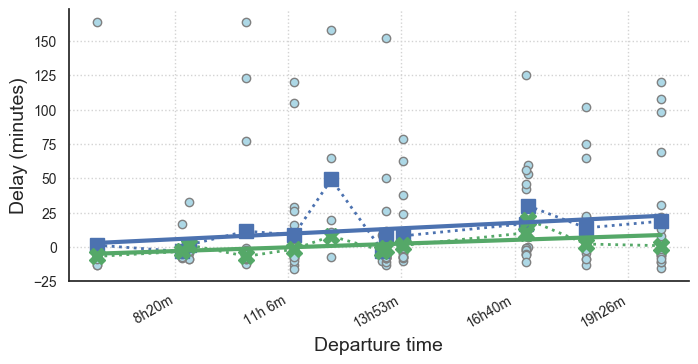

In [140]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['heure_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

First of all, in this figure, the points corresponding to the individual flights are represented by the points in gray.
The mean of these points gives the mean delays and the mean of the set of initial points corresponds to the blue squares. By removing extreme delays (> 1h), one obtains the average delays represented by the green crosses.
Thus, in the first case, the fit (solid blue curve) leads to a prediction which corresponds to an average delay of $\sim$ 10 minutes larger than the predicton obtained in the second case (green curve), and this, at any hour of the day.

In conclusion, we see in this example that the way in which we manage the extreme delays will have an important impact on the modeling. Note, however, that the current example corresponds to a *chosen case* where the impact of extreme delays is magnified by the limited number of flights. Presumably, the impact of such delays will be less pronounced in the majority of cases.

___
#### 5.1.2 Polynomial degree: splitting the dataset


In practice, rather than performing a simple linear regression, we can improve the model doing a fit with a polynomial of order $N$. Doing so, it is necessary to define the degree $N$ which is optimal to represent the data. When increasing the polynomial order, it is important ** to prevent over-fitting** and we do this by splitting the dataset in **test and training sets**. A problem that may arise with this procedure is that the model ends by *indirectly* learning the contents of the test set and is thus biased. To avoid this, the data can be re-separated into 3 sets: *train*, *test* and *validation*. An alternative to this technique, which is often more robust, is the so-called cross-validation method. This method consists of performing a first separation of the data in *training* and *test* sets. As always, learning is done on the training set, but to avoid over-learning, it is split into several pieces that are used alternately for training and testing.

Note that if the data set is small, the separation in test & training sets can introduce a bias in the estimation of the parameters. In practice, the *cross-validation* method avoids such bias. In fact, in the current model, we will encounter this type of problem and in what follows, I will highlight this. For example, we can consider an extreme case where, after separation, the training set would contain only hours $<$20h and the test set would have hours$>$ 20h. The model would then be unable to reproduce precisely this data, of which it would not have seen equivalent during the training. The cross-validation method avoids this bias because all the data are used successively to drive the model.

** a) Bias introduced by the separation of the data set **

In order to test the impact of data separation on model determination, I first define the class * fit_polynome *:

In [141]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

The * fit_polynome * class allows you to perform all operations related to a fit and to save the results. When calling the  **split()** method, the variable '*method*' defines how the initial data is separated:
- *method = 'all' *: all input data is used to train and then test the model
- *method = 'split' *: we use the * train_test_split() * method of sklearn to define test & training sets
 
Then, the other methods of the class have the following functions:
- ** train (n) **: drives the data on the training set and makes a polynomial of order n
- ** predict (X) **: calculates the Y points associated with the X input and for the previously driven model
- ** calc_score () **: calculates the model score in relation to the test set data

In order to illustrate the bias introduced by the selection of the test set, I proceed in the following way: I carry out several "train / test" separation of a data set and for each case, I fit polynomials of orders ** n = 1, 2 and 3 **, by calculating their respective scores. Then, I show that according to the choice of separation, the best score can be obtained with any of the values ​​of ** n **. In practice, it is enough to carry out a dozen models to obtain this result. Moreover, this bias is introduced by the choice of the separation "train / test" and results from the small size of the dataset to be modeled. In fact, in the following, I take as an example the case of the airline * American Airlines * (the second biggest airline) and the airport of id 1129804, which is the airport with the most registered flights for that company. This is one of the least favorable scenarios for the emergence of this kind of bias, which, nevertheless, is present:

modèle nº1 , min. pour n = 1, score = 49.1
modèle nº2 , min. pour n = 1, score = 145.6
modèle nº3 , min. pour n = 1, score = 147.1
modèle nº4 , min. pour n = 1, score = 126.1
modèle nº5 , min. pour n = 2, score = 200.2
modèle nº6 , min. pour n = 1, score = 22.1
modèle nº7 , min. pour n = 1, score = 61.2
modèle nº8 , min. pour n = 1, score = 50.6
modèle nº9 , min. pour n = 3, score = 10.7


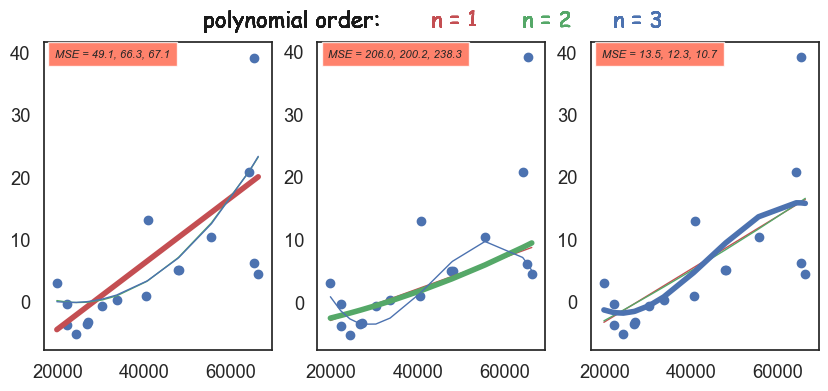

In [142]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break

In this figure, the panels from left to right correspond to 3 separations of the data in train and test sets, for which the best models are obtained respectively with polynomials of order 1, 2 and 3. On each of these panels the 3 fits polynomials have been represented and the best model corresponds to the thick curve.

** b) Selection by cross-validation**

One of the advantages of the cross-validation method is that it avoids the bias that has just been put forward when choosing the polynomial degree. In order to use this method, I define a new class that I will use later to perform the fits:

In [143]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))

This class has two methods:
- ** train (n, nb_folds) **: defined 'nb_folds' training sets from the initial dataset and drives a 'n' order polynomial on each of these sets. This method returns as a result the Y predictions obtained for the different test sets.
- ** calc_score (n, nb_folds) **: performs the same procedure as a ** train ** method except that this method calculates the fit score and not the predicted values ​​on the different test data.

By default, the *'K-fold'* method is used by sklearn * cross_val_predict () * and * cross_val_score () * methods. These methods are deterministic in the choice of the K folds, which implies that for a fixed K value, the results obtained using these methods will always be identical. As seen in the previous example, this was not the case when using the *train_test_split()* method. Thus, if we take the same dataset as in the previous example, the method of cross validation makes it possible to choose the best polynomial degree:

In [147]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Max possible number of folds: 16 



ValueError: 'mean_squared_error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

We can see that using this method gives us that the best model (ie the best generalized model) is obtained with a polynomial of order 2. At this stage of the procedure, the choice of the polynomial order a has been validated and we can now use all the data in order to perform the fit:

In [148]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)

Thus, in the following figure, the juxtaposition of the K = 50 polynomial fits corresponding to the cross validation calculation leads to the red curve. The polynomial fit corresponding to the final model corresponds to the blue curve.

In [149]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

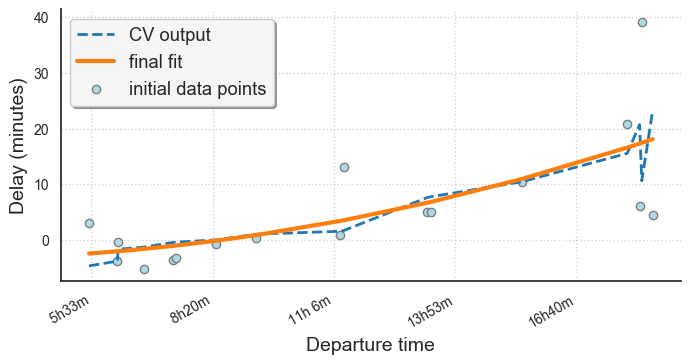

In [150]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [151]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

56.86284771892095

#### 5.1.3 Model test: prediction of end-January delays

At this stage, the model was driven is tested on the training set which include the data of the first 3 weeks of January. We now look at the comparison of predictions and observations for the fourth week of January:

In [152]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

and the MSE score of the model is:

In [153]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

108.67130851577083

To get an idea of the meaning of such a value for the MSE, we can assume a constant error on each point of the dataset. In which case, at each point $ i $, we have:

\begin{eqnarray}
y_i - f(x_i) = cste = \sqrt{MSE}
\end{eqnarray}

thus giving the difference in minutes between the predicted delay and the actual delay. In this case, the difference between the model and the observations is thus typically:

In [154]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 10.42 min'

___
### 5.2 Model nº2: One airline, all airports

In the previous section, the model only considered one airport. This procedure is potentially inefficient because it is likely that some of the observations can be extrapolated from an ariport to another. Thus, it may be advantageous to make a single fit, which would take all the airports into account. In particular, this will allow to predict delays on airports for which the number of data is low with a better accuracy.

In [155]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [156]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(1831, 3)

In the *merged_df* dataframe, airports are referenced by an identifier given in the ** ORIGIN_AIRPORT** variable.
The corresponding labels can't be used directly in a fit and I thus use the *one-hot-encoding* method:

In [157]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

Above, I have assigned a label to each airport. The correspondence between the label and the original identifier has been saved in the *label_airport* list. Now I proceed with the "One Hot Encoding" by creating a matrix where instead of the **ORIGIN_AIRPORT** variable that contained $M$ labels, we build a matrix with $M$ columns, filled of 0 and 1 depending on the correspondance with particular airports:

In [158]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1831, 82) (1831, 1)


___
#### 5.2.1 Linear regression

The matrices X and Y thus created can be used to perform a linear regression:

In [159]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

MSE = 53.7430736542386


Here, I calculated the MSE score of the fit. In practice, we can have a feeling of the quality of the fit by considering the number of predictions where the differences with real values is greater than 15 minutes:

In [160]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

'5.30%'

In practice, this model tends to underestimate the large delays, which can be seen in the following figure:

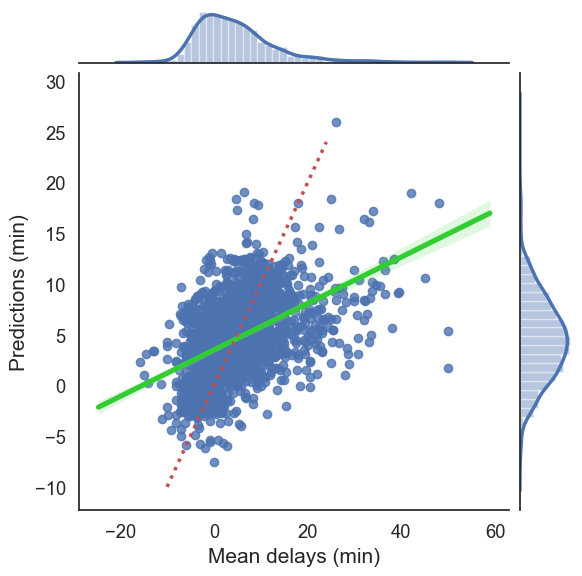

In [161]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

___
#### 5.2.2 Polynomial regression

I will now extend the previous fit by using a polynomial rather than a linear function:

In [162]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [163]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 49.50254261435343


We can see that a polynomial fit improves slightly the MSE score. In practice, the percentage of values where the difference between predictions and real delays is greater than 15 minutes is:

In [164]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

'4.81%'

And as before, it can be seen that model tends to be worse in the case of large delays:

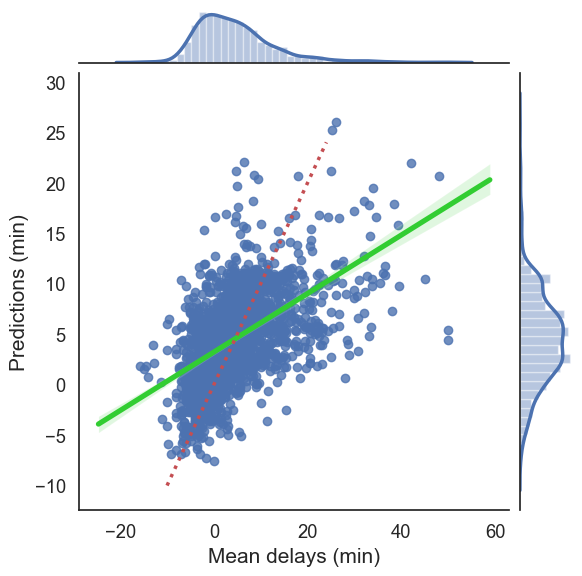

In [165]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

___
#### 5.2.3 Setting the free parameters

Above, the two models were fit and tested on the training set. In practice, as mentioned above, there is a risk of overfitting by proceeding that way and the free parameters of the model will be biased. Hence,  the model will not allow a good generalization. In what follows, I will therefore split the datas in order to train and then test the model. The purpose will be to determine the polynomial degree which allows the best generalization of the predictions:

In [167]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

As before, I fit the model on the training set:

In [168]:
X_train.shape

(1281, 82)

In [169]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Mean squared error =  46.90431624311941


Now, by testing on the test set we get:

In [170]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  258.599393938996


Here, we see that the **fit is particularly bad with a MSE > 500** (the exact value depends on the run and on the splitting of the dataset), which means that the fit performs poorly when generalyzing to other data. Now let's examine in detail the reasons why we have such a bad score. Below, I examing all the terms of the MSE calculation and identify the largest terms:

In [171]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

37505.2 -167.7 26.0
35570.5 -177.0 11.6
30169.1 -177.2 -3.5


We see that some predictions show very large errors. In practice, this can be explained by the fact that during the separation in train and test sets, **data with no equivalent in the training set was put in the test data**. Thus, when calculating the prediction, the model has to **perform an extrapolation**. If the coefficients of the fit are large (which is often the case when overfitting), extrapolated values will show important values, as in the present case. In order to have a control over this phenomenon, we can use a **regularization method** which will put a penalty to the models whose coefficients are the most important:

In [172]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

Now, if we calculate the score associated to the predictions made with a regularization technique, we have:

In [173]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  66.62288068413866


And we can see that we obtain a reasonnable score. Hence, with the current procedure, to determine the best model, we have two free parameters to adjust: the polynomial order and the $\alpha$ coefficient of the * 'Ridge Regression' *:

In [174]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 67.466
n=1 alpha=2 , MSE = 65.742
n=1 alpha=4 , MSE = 65.076
n=1 alpha=6 , MSE = 64.887
n=1 alpha=8 , MSE = 64.926
n=1 alpha=10 , MSE = 65.076
n=1 alpha=12 , MSE = 65.279
n=1 alpha=14 , MSE = 65.504
n=1 alpha=16 , MSE = 65.735
n=1 alpha=18 , MSE = 65.963
n=2 alpha=0 , MSE = 99.127
n=2 alpha=2 , MSE = 66.791
n=2 alpha=4 , MSE = 66.489
n=2 alpha=6 , MSE = 66.276
n=2 alpha=8 , MSE = 66.123
n=2 alpha=10 , MSE = 66.02
n=2 alpha=12 , MSE = 65.959
n=2 alpha=14 , MSE = 65.93
n=2 alpha=16 , MSE = 65.927
n=2 alpha=18 , MSE = 65.943


This grid search allows to find the best set of $\alpha$ and $n$ parameters. Let us note, however, that for this model, the estimates obtained with a linear regression or a polynomial of order 2 are quite close. Now I use these parameters to test this template over the test set:

In [175]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

55.892912799059864


#### 6.2.4 Testing the model: delays of end-january


At this stage, model predictions are tested against end-January data. These data are first extracted:

In [176]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

then I convert them into a format suitable to perform the fit. At this stage, I manually do one-hot-encoding by re-using the labeling that had been established on the training data:

In [177]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['heure_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

I can then create the predictions

In [178]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

'MSE = 58.41'


As before, assuming that the delay is independent of the point, this MSE score is equivalent to an average delay of:

In [179]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 7.64 min'

The current MSE score is calculated on all the airports served by _American Airlines_, whereas previously it was calculated on the data of a single airport. The current model is therefore more general. Moreover, considering the previous model, it is likely that predictions will be poor for airports with low statistics.
____
## 6.3 Model nº3: Accounting for destinations

In the previous model, I grouped the flights per departure time. Thus, flights with different destinations were grouped as soon as they leave at the same time. Now I make a model that accounts for both departure and arrival times:

In [180]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [181]:
df3 = create_df(df, carrier)    
df3[:5]

,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,2.133333,2.800000
1,300,17700,LAX,5.500000,3.750000
2,600,28200,LAX,-6.000000,3.250000
3,1200,29040,LAX,-4.117647,2.823529
4,1200,29100,LAX,0.800000,3.600000


In [182]:
df3.head()

,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,2.133333,2.800000
1,300,17700,LAX,5.500000,3.750000
2,600,28200,LAX,-6.000000,3.250000
3,1200,29040,LAX,-4.117647,2.823529
4,1200,29100,LAX,0.800000,3.600000


Henceforth, regroupings are made on departure and arrival times, and the (specific) airports of origin and destination are implicitly taken into account. As before, I carry out the encoding of the airports:

In [183]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

___
#### 6.3.1 Choice of model parameters

As before, I will perform a regression with regularization and I will have to define the value to attribute to the parameter $\alpha$. I therefore separate the data to train and then test the model to select the best value for $\alpha$:

In [184]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [185]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 78.584
n=1 alpha=0.2 , MSE = 77.605
n=1 alpha=0.4 , MSE = 77.464
n=1 alpha=0.6 , MSE = 77.727
n=1 alpha=0.8 , MSE = 78.189
n=1 alpha=1.0 , MSE = 78.744
n=1 alpha=1.2 , MSE = 79.336
n=1 alpha=1.4 , MSE = 79.933
n=1 alpha=1.6 , MSE = 80.518
n=1 alpha=1.8 , MSE = 81.083
n=2 alpha=0.0 , MSE = 2235.6
n=2 alpha=0.2 , MSE = 79.186
n=2 alpha=0.4 , MSE = 78.68
n=2 alpha=0.6 , MSE = 78.44
n=2 alpha=0.8 , MSE = 78.307
n=2 alpha=1.0 , MSE = 78.242
n=2 alpha=1.2 , MSE = 78.227
n=2 alpha=1.4 , MSE = 78.252
n=2 alpha=1.6 , MSE = 78.309
n=2 alpha=1.8 , MSE = 78.391


In [186]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

89.55031772741047


#### 6.3.2 Test of the model: late January delays

Now I test the quality of the predictions on the data of the last week of January. I first extract these data:

In [187]:
df3 = create_df(df_test, carrier)    
df3[:5]

,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,-4.000,3.25
1,1200,29040,LAX,5.125,3.25
2,1800,20340,SFO,-6.750,3.25
3,2700,29340,LAS,-4.500,3.25
4,3900,31800,LAX,-4.875,3.25


In [188]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['ORIGIN_AIRPORT'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = df3['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['heure_depart', 'heure_arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [189]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

MSE = 74.8


which corresponds to an average delay of:

In [190]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 8.65 min'

In [191]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(predictions))*100,3)))

ecarts > 15 minutes: 4.588%


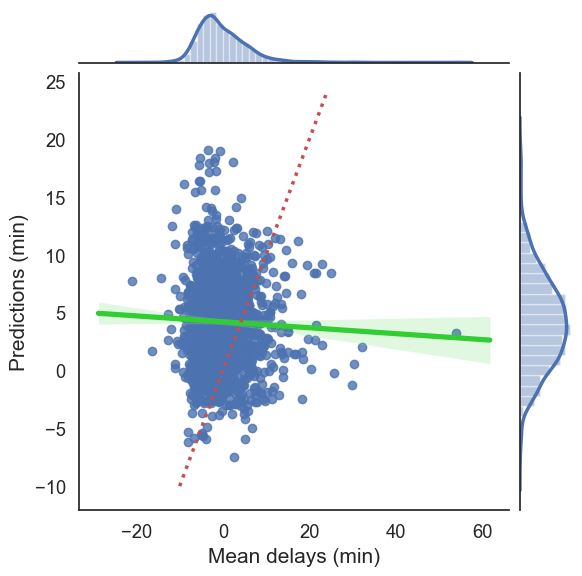

In [192]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

## Conclusion

These notebook was two-fold. The first part dealt with an exploration of the dataset, with the aim of understanding some properties of the delays registered by flights. This exploration gave me the occasion of using various vizualization tools offered by python. The second part of the notebook consisted in the elaboration of a model aimed at predicting flight delays. For that purpose, I used polynomial regressions and showed the importance of regularisation techniques. In fact, I only used ridge regression but it is important to keep in mind that other regularisations techniques could be more appropriate ( e.g Lasso or Elastic net). 

